Author: A. N. M. Sajedul Alam

My GPU Information

In [1]:
!nvidia-smi

Mon Oct 24 11:11:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Grabbing the diffusers from Hugging Face

In [19]:
! pip install https://github.com/huggingface/diffusers/archive/main.zip -qUU --force-reinstall


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.1.4 requires typing-extensions<4.2.0,>=3.7.4.1; python_version < "3.8", but you have typing-extensions 4.4.0 which is incompatible.
spacy 3.4.1 requires typing-extensions<4.2.0,>=3.7.4; python_version < "3.8", but you have typing-extensions 4.4.0 which is incompatible.
confection 0.0.3 requires typing-extensions<4.2.0,>=3.7.4.1; python_version < "3.8", but you have typing-extensions 4.4.0 which is incompatible.


In [20]:
!pip install -qq -U diffusers transformers ftfy
!pip install -qq "ipywidgets>=7,<8"

In [21]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


In [74]:
!pip install --upgrade diffusers transformers scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [75]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline

model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda"


pipe = StableDiffusionPipeline.from_pretrained(model_id, use_auth_token=True)
pipe = pipe.to(device)

prompt = "a photo of an astronaut riding a horse on mars"
with autocast("cuda"):
    image = pipe(prompt, guidance_scale=7.5).images[0]  
    
image.save("astronaut_rides_horse.png")


Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/230 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/592 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/492M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/806 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/743 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/522 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

  0%|          | 0/51 [00:00<?, ?it/s]

In [40]:
import inspect
from typing import List, Optional, Union

import numpy as np
import torch

import PIL
from diffusers import AutoencoderKL, DDIMScheduler, DiffusionPipeline, PNDMScheduler, UNet2DConditionModel
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer


def preprocess(image):
    w, h = image.size
    w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
    image = image.resize((w, h), resample=PIL.Image.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.0 * image - 1.0


class StableDiffusionImg2ImgPipeline(DiffusionPipeline):
    def __init__(
        self,
        vae: AutoencoderKL,
        text_encoder: CLIPTextModel,
        tokenizer: CLIPTokenizer,
        unet: UNet2DConditionModel,
        scheduler: Union[DDIMScheduler, PNDMScheduler],
        safety_checker: StableDiffusionSafetyChecker,
        feature_extractor: CLIPFeatureExtractor,
    ):
        super().__init__()
        scheduler = scheduler.set_format("pt")
        self.register_modules(
            vae=vae,
            text_encoder=text_encoder,
            tokenizer=tokenizer,
            unet=unet,
            scheduler=scheduler,
            safety_checker=safety_checker,
            feature_extractor=feature_extractor,
        )

    @torch.no_grad()
    def __call__(
        self,
        prompt: Union[str, List[str]],
        init_image: torch.FloatTensor,
        strength: float = 0.8,
        num_inference_steps: Optional[int] = 50,
        guidance_scale: Optional[float] = 7.5,
        eta: Optional[float] = 0.0,
        generator: Optional[torch.Generator] = None,
        output_type: Optional[str] = "pil",
    ):

        if isinstance(prompt, str):
            batch_size = 1
        elif isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            raise ValueError(f"`prompt` has to be of type `str` or `list` but is {type(prompt)}")

        # set timesteps
        accepts_offset = "offset" in set(inspect.signature(self.scheduler.set_timesteps).parameters.keys())
        extra_set_kwargs = {}
        offset = 0
        if accepts_offset:
            offset = 1
            extra_set_kwargs["offset"] = 1

        self.scheduler.set_timesteps(num_inference_steps, **extra_set_kwargs)

        # encode the init image into latents and scale the latents
        init_latents = self.vae.encode(init_image.to(self.device)).sample()
        init_latents = 0.18215 * init_latents

        # prepare init_latents noise to latents
        init_latents = torch.cat([init_latents] * batch_size)

        # get the original timestep using init_timestep
        init_timestep = int(num_inference_steps * strength) + offset
        init_timestep = min(init_timestep, num_inference_steps)
        timesteps = self.scheduler.timesteps[-init_timestep]
        timesteps = torch.tensor([timesteps] * batch_size, dtype=torch.long, device=self.device)

        # add noise to latents using the timesteps
        noise = torch.randn(init_latents.shape, generator=generator, device=self.device)
        init_latents = self.scheduler.add_noise(init_latents, noise, timesteps)

        # get prompt text embeddings
        text_input = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        text_embeddings = self.text_encoder(text_input.input_ids.to(self.device))[0]

        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0
        # get unconditional embeddings for classifier free guidance
        if do_classifier_free_guidance:
            max_length = text_input.input_ids.shape[-1]
            uncond_input = self.tokenizer(
                [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
            )
            uncond_embeddings = self.text_encoder(uncond_input.input_ids.to(self.device))[0]

            # For classifier free guidance, we need to do two forward passes.
            # Here we concatenate the unconditional and text embeddings into a single batch
            # to avoid doing two forward passes
            text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

        # prepare extra kwargs for the scheduler step, since not all schedulers have the same signature
        # eta (η) is only used with the DDIMScheduler, it will be ignored for other schedulers.
        # eta corresponds to η in DDIM paper: https://arxiv.org/abs/2010.02502
        # and should be between [0, 1]
        accepts_eta = "eta" in set(inspect.signature(self.scheduler.step).parameters.keys())
        extra_step_kwargs = {}
        if accepts_eta:
            extra_step_kwargs["eta"] = eta

        latents = init_latents
        t_start = max(num_inference_steps - init_timestep + offset, 0)
        for i, t in tqdm(enumerate(self.scheduler.timesteps[t_start:])):
            # expand the latents if we are doing classifier free guidance
            latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents

            # predict the noise residual
            noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

            # perform guidance
            if do_classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs)["prev_sample"]

        # scale and decode the image latents with vae
        latents = 1 / 0.18215 * latents
        image = self.vae.decode(latents)

        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.cpu().permute(0, 2, 3, 1).numpy()

        # run safety checker
        safety_cheker_input = self.feature_extractor(self.numpy_to_pil(image), return_tensors="pt").to(self.device)
        image, has_nsfw_concept = self.safety_checker(images=image, clip_input=safety_cheker_input.pixel_values)

        if output_type == "pil":
            image = self.numpy_to_pil(image)

        return {"sample": image, "nsfw_content_detected": has_nsfw_concept}

In [41]:
!wget https://raw.githubusercontent.com/huggingface/diffusers/4674fdf807cdefd4db1758067c0207872d805f8c/examples/inference/image_to_image.py

--2022-10-24 11:48:03--  https://raw.githubusercontent.com/huggingface/diffusers/4674fdf807cdefd4db1758067c0207872d805f8c/examples/inference/image_to_image.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6808 (6.6K) [text/plain]
Saving to: ‘image_to_image.py’

image_to_image.py   100%[===================>]   6.65K  --.-KB/s    in 0s      

2022-10-24 11:48:03 (97.5 MB/s) - ‘image_to_image.py’ saved [6808/6808]



In [22]:
! pip install --ignore-installed Pillow==9.0.0


# this fixes the module 'PIL.Image' has no attribute 'Resampling' error


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached Pillow-9.0.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.3 MB)


In [77]:
from torch import autocast
import torch
import requests
from PIL import Image
from io import BytesIO

from diffusers import StableDiffusionImg2ImgPipeline


In [78]:
# load the pipeline
device = "cuda"
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    revision="fp16", 
    torch_dtype=torch.float16,
    use_auth_token=True
).to(device)

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

In [79]:
# let's download an initial image
url = "https://www.hoteldesgrandshommes.com/uploads/images/monuments/hc-a-eu-france-paris-eiffel-tower.jpg"

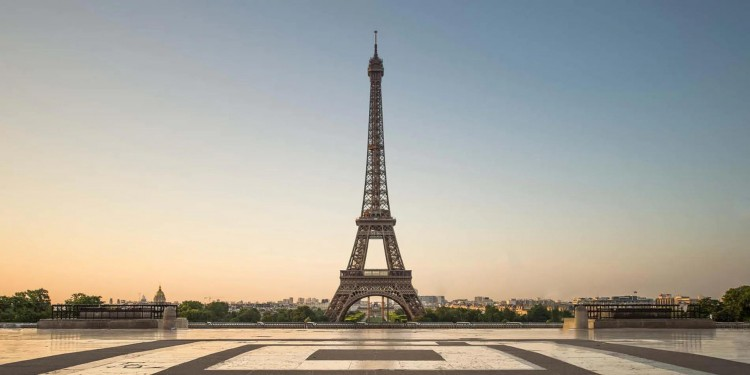

In [80]:
response = requests.get(url)
init_image = Image.open(BytesIO(response.content)).convert("RGB")
init_image

In [81]:
init_image = init_image.resize((768, 512))
#init_image = preprocess(init_image)

In [96]:
prompt = "a lot of fireworks in the dark sky with eiffel tower"

In [60]:
!pip install --upgrade diffusers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [61]:
!pip install --upgrade torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
!python ‐‐v

python3: can't open file '‐‐v': [Errno 2] No such file or directory


In [62]:
with autocast("cuda"):
    images = pipe(prompt=prompt, init_image=init_image, strength=0.75, guidance_scale=7.5)


  0%|          | 0/38 [00:00<?, ?it/s]

In [97]:
with autocast("cuda"):
    image = pipe(prompt=prompt, init_image=init_image, strength=0.75, guidance_scale=7.5).images[0]  

  0%|          | 0/38 [00:00<?, ?it/s]

In [84]:
image.save("dark-sky-with-eiffel-tower.png")

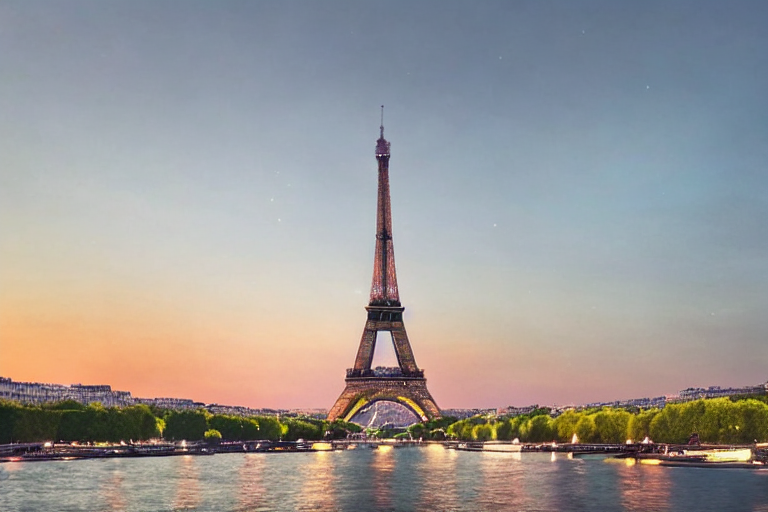

In [98]:
image

In [91]:
init_image = image

In [99]:
prompt = "a lot of fireworks at night at eiffel tower"

In [100]:
with autocast("cuda"):
    image = pipe(prompt=prompt, init_image=init_image, strength=0.75, guidance_scale=7.5).images[0]

  0%|          | 0/38 [00:00<?, ?it/s]

In [101]:
image.save("fireworks-night-eiffel-tower.png")

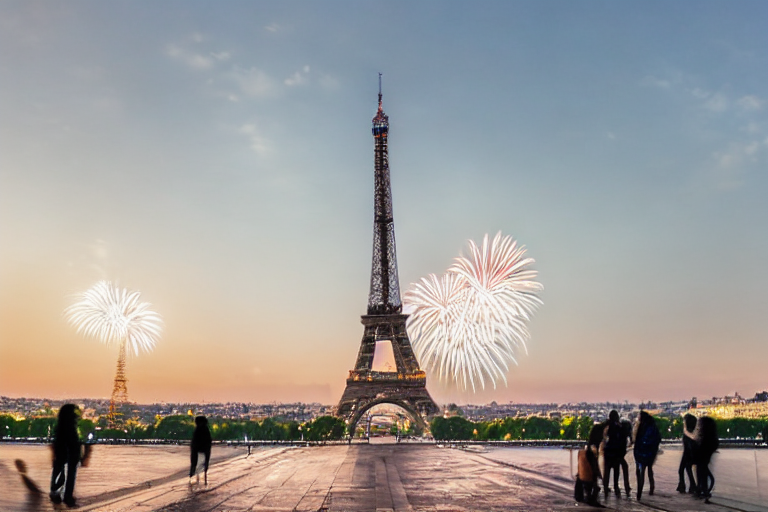

In [102]:
image

In [103]:
init_image = image

In [104]:
prompt = "a lot of stars and eiffel tower"

In [105]:
with autocast("cuda"):
    image = pipe(prompt=prompt, init_image=init_image, strength=0.75, guidance_scale=7.5).images[0]

  0%|          | 0/38 [00:00<?, ?it/s]

In [106]:
image.save("stars-and-eiffel-tower.png")

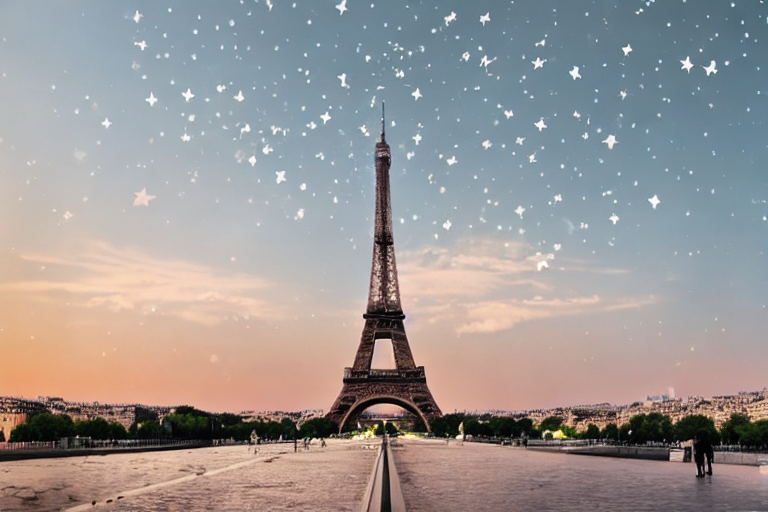

In [107]:
image

In [108]:
init_image = image

In [109]:
prompt = "a rocket with eiffel tower"

In [110]:
with autocast("cuda"):
    image = pipe(prompt=prompt, init_image=init_image, strength=0.75, guidance_scale=7.5).images[0]

  0%|          | 0/38 [00:00<?, ?it/s]

In [111]:
image.save("rocket-and-eiffel-tower.png")

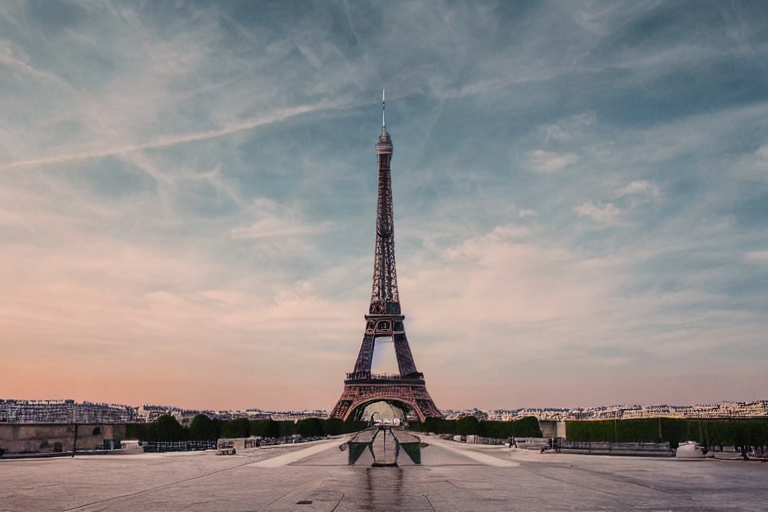

In [112]:
image